# Importación de librerías y carga de datos

In [23]:
# Importación de librerías necesarias

import pandas as pd 
import seaborn as sns                                                   
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, \
                                    cross_val_score, \
                                    learning_curve
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets, metrics
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from boruta import BorutaPy
from tpot import TPOTClassifier

# Rutas donde cada persona tiene los df locales, de la carpeta de OneDrive
# Copiar la ruta como una variable y cambiar la varibale en el siguiente
# bloque de código.

path_santiago = r'C:\Users\santi\Universidad de Antioquia\VALERIA CADAVID CASTRO - Resultados_Armonizacion_BD'
path_veronica = r'C:\Users\veroh\OneDrive - Universidad de Antioquia\Resultados_Armonizacion_BD'

In [2]:
path = path_santiago

In [3]:
data = pd.read_feather(r'{path}\Datosparaorganizardataframes\Data_complete_ic_neuroHarmonize_G1.feather'.format(path=path))

In [4]:
data

,power_C14_Delta,power_C14_Theta,power_C14_Alpha-1,power_C14_Alpha-2,power_C14_Beta1,power_C14_Beta2,power_C14_Beta3,power_C14_Gamma,power_C15_Delta,power_C15_Theta,...,crossfreq_C24_Mbeta3_Gamma,crossfreq_C24_Mgamma_Gamma,crossfreq_C25_Mdelta_Gamma,crossfreq_C25_Mtheta_Gamma,crossfreq_C25_Malpha-1_Gamma,crossfreq_C25_Malpha-2_Gamma,crossfreq_C25_Mbeta1_Gamma,crossfreq_C25_Mbeta2_Gamma,crossfreq_C25_Mbeta3_Gamma,crossfreq_C25_Mgamma_Gamma
0,0.186927,0.063808,0.082152,0.090405,0.176768,0.083747,0.122689,0.193504,0.397332,0.083051,...,0.175592,0.660878,0.123818,0.016349,0.026090,0.035218,0.069914,0.018539,0.089809,0.279009
1,0.303421,0.100647,0.211855,0.121404,0.106804,0.054898,0.086855,0.014116,0.353285,0.110086,...,0.093619,0.261124,0.146237,0.035522,0.223624,0.147397,0.087232,0.014432,0.044372,0.096536
2,0.309907,0.099577,0.087386,0.085328,0.114095,0.032154,0.098118,0.173435,0.458282,0.133867,...,0.149689,0.419643,0.072678,0.015694,0.022912,0.037863,0.053656,0.010985,0.106195,0.184318
3,0.108792,0.072188,0.164554,0.159235,0.172716,0.050523,0.177457,0.094535,0.166930,0.123981,...,0.078410,0.193753,0.082567,0.033294,0.079884,0.098578,0.071779,0.013630,0.083936,0.142481
4,0.206763,0.091237,0.091652,0.094457,0.153634,0.057392,0.135485,0.169380,0.286844,0.122263,...,0.049441,0.101489,0.078834,0.046049,0.061689,0.073515,0.052699,0.008886,0.044686,0.089752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,0.126269,0.085563,0.131598,0.065546,0.143790,0.046511,0.362139,0.038584,0.205020,0.108680,...,0.045326,0.109461,0.082015,0.141946,0.272191,0.154794,0.051662,0.011231,0.128292,0.243913
143,0.175882,0.070602,0.130953,0.141161,0.217872,0.071974,0.127013,0.064544,0.234591,0.087727,...,0.026151,0.049714,0.090795,0.057919,0.120392,0.100469,0.083024,0.015510,0.031198,0.064425
144,0.085603,0.068231,0.417529,0.099008,0.073792,0.043209,0.060917,0.151710,0.072220,0.061290,...,0.073712,0.224798,0.072781,0.102536,0.213331,0.174010,0.076355,0.018067,0.065522,0.138696
145,0.201935,0.063966,0.125468,0.223393,0.149015,0.032869,0.073776,0.129578,0.446617,0.140551,...,0.061358,0.199445,0.131020,0.044999,0.132653,0.267126,0.177317,0.015834,0.049969,0.110130


In [5]:
print(f'sujetos: {data.shape[0]} | caracteristicas: {data.shape[1]}')

sujetos: 147 | caracteristicas: 557


# Preprocesamiento

## Análisis exploratorio de datos

In [6]:
# Se visualizan cuantos elementos hay de cada grupo

for group in data['group'].unique():
        
        print('{} : {}'.format(group, (data['group']==group).sum()))

G1 : 49
Control : 98


In [7]:
# Se visualizan los descriptores

data.describe()


,power_C14_Delta,power_C14_Theta,power_C14_Alpha-1,power_C14_Alpha-2,power_C14_Beta1,power_C14_Beta2,power_C14_Beta3,power_C14_Gamma,power_C15_Delta,power_C15_Theta,...,crossfreq_C24_Mbeta3_Gamma,crossfreq_C24_Mgamma_Gamma,crossfreq_C25_Mdelta_Gamma,crossfreq_C25_Mtheta_Gamma,crossfreq_C25_Malpha-1_Gamma,crossfreq_C25_Malpha-2_Gamma,crossfreq_C25_Mbeta1_Gamma,crossfreq_C25_Mbeta2_Gamma,crossfreq_C25_Mbeta3_Gamma,crossfreq_C25_Mgamma_Gamma
count,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,...,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000
mean,0.183748,0.080780,0.149222,0.144321,0.152437,0.056073,0.117317,0.116103,0.265128,0.106917,...,0.081591,0.231259,0.108253,0.058105,0.128244,0.120430,0.096665,0.022292,0.084997,0.172090
std,0.083319,0.032318,0.081127,0.078630,0.055206,0.023521,0.047499,0.087989,0.105793,0.038181,...,0.058975,0.263286,0.027788,0.033925,0.090059,0.091412,0.076421,0.020196,0.066475,0.153898
min,0.034128,0.021356,0.029124,0.034314,0.045217,0.024785,0.041340,-0.159345,0.060262,0.030883,...,0.016605,0.035185,0.054425,0.011792,0.006935,0.012117,0.018340,0.003866,0.014585,0.031526
25%,0.115707,0.061608,0.091327,0.087963,0.111700,0.040883,0.088494,0.076972,0.181331,0.079853,...,0.045326,0.087019,0.090571,0.033166,0.060700,0.057318,0.052012,0.011358,0.043694,0.084635
50%,0.173592,0.074742,0.128918,0.126409,0.144360,0.050972,0.109295,0.111680,0.247388,0.102125,...,0.061965,0.147631,0.105426,0.049090,0.108752,0.101472,0.076355,0.017367,0.063911,0.135151
75%,0.236741,0.093637,0.197310,0.186041,0.176051,0.066306,0.137082,0.145919,0.344551,0.123990,...,0.100256,0.240962,0.124855,0.075144,0.187009,0.160083,0.117980,0.026331,0.106432,0.205840
max,0.514918,0.224500,0.482734,0.528539,0.325770,0.171666,0.362139,0.566807,0.519410,0.257018,...,0.433171,1.979020,0.189054,0.197069,0.454054,0.444413,0.606438,0.194359,0.374769,1.205670


In [8]:
# Agrupada por sujetos

data.groupby(by='group').describe().T

group                               Control         G1
power_C14_Delta            count  98.000000  49.000000
                           mean    0.191006   0.169233
                           std     0.085846   0.076815
                           min     0.045354   0.034128
                           25%     0.126121   0.105929
...                                     ...        ...
crossfreq_C25_Mgamma_Gamma min     0.037968   0.031526
                           25%     0.079453   0.096536
                           50%     0.125734   0.148974
                           75%     0.168739   0.239197
                           max     1.205670   0.586838

[4408 rows x 2 columns]

In [9]:
# Se muestran las columnas eliminadas debido a que tienen datos faltantes

for column in data.columns:

    if data[column].isna().sum() != 0:

        print('{} : {}'.format(column, (data[column].isna().sum())))
        data.drop(column, axis=1, inplace=True)

MM_total : 41
FAS_F : 78
FAS_S : 78
FAS_A : 78
education : 41


In [11]:
# Tamaño del dataset luego de eliminar columnas 
print(f'sujetos: {data.shape[0]} | caracteristicas: {data.shape[1]}')

sujetos: 147 | caracteristicas: 552


In [12]:
# Se mapean las clases 

clases_mapeadas = {label:idx for idx,label in enumerate(np.unique(data['group']))}
data.loc[:,'group'] = data.loc[:,'group'].map(clases_mapeadas) 
print(clases_mapeadas)

{'Control': 0, 'G1': 1}


In [13]:
# tipos de datos que se tienen en el dataFrame

print(data.dtypes.unique())

[dtype('float64') dtype('O') dtype('int64')]


In [14]:
data.select_dtypes('O')

,database,participant_id,visit,condition,sex
0,BIOMARCADORES,sub-G1024,V0,CE,M
1,BIOMARCADORES,sub-G1023,V0,CE,F
2,BIOMARCADORES,sub-G1022,V0,CE,F
3,BIOMARCADORES,sub-G1021,V0,CE,F
4,BIOMARCADORES,sub-G1019,V0,CE,F
...,...,...,...,...,...
142,CHBMP,sub-CBM00167,V0,protmap,M
143,CHBMP,sub-CBM00156,V0,protmap,F
144,CHBMP,sub-CBM00147,V0,protmap,F
145,CHBMP,sub-CBM00283,V0,protmap,F


In [15]:
data.groupby(by='sex').describe().T

sex                                       F          M
power_C14_Delta            count  79.000000  68.000000
                           mean    0.181543   0.186310
                           std     0.075967   0.091634
                           min     0.061581   0.034128
                           25%     0.110649   0.125566
...                                     ...        ...
crossfreq_C25_Mgamma_Gamma min     0.038953   0.031526
                           25%     0.096945   0.065800
                           50%     0.135687   0.133209
                           75%     0.170433   0.217572
                           max     0.813485   1.205670

[4376 rows x 2 columns]

In [16]:
# es necesario mapear el sexo, para que tome valor númerico

clases_mapeadas = {label:idx for idx,label in enumerate(np.unique(data['sex']))}
data.loc[:,'sex'] = data.loc[:,'sex'].map(clases_mapeadas) 
print(clases_mapeadas)

{'F': 0, 'M': 1}


In [17]:
# data pasa a ser el arreglo únicamente con los datos númericos

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

data = data.select_dtypes(include=numerics)

data.shape

(147, 548)

In [18]:
# Se elimina la columna, para ponerla al final

target = data.pop('group')
data.insert(len(data.columns), target.name, target)

## Selección de caracteristicas

### Creación de datasets

In [20]:
X = data.values[:,:-1]
y = data.values[:,-1]
print(X.shape)
print(y.shape)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(                            
    X, # Valores de X
    y, # Valores de Y
    test_size=0.2, # Test de 20%
    random_state=1, # Semilla
    stratify=data.values[:,-1]) # que se mantenga la proporcion en la división

### Mapa de calor de correlación

<AxesSubplot:>

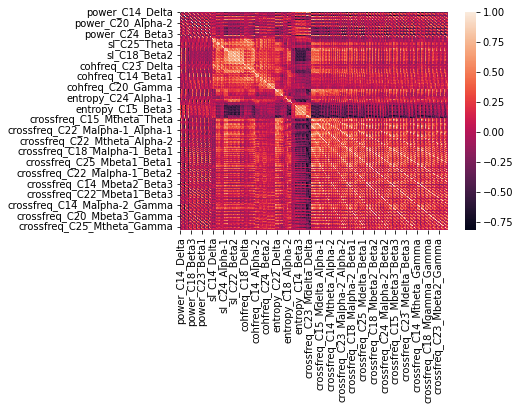

In [55]:
sns.heatmap(data.corr())

### Árboles de decisión (Boruta)

In [22]:
forestclf = RandomForestClassifier(n_estimators=1000,
    criterion='entropy',                        
    random_state=1)

In [58]:
feat_selector = BorutaPy(
    verbose=2,
    estimator=forestclf,
    n_estimators='auto',
    max_iter=100  # number of iterations to perform
)

In [59]:
feat_selector.fit(X_train, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	544
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	544
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	544
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	544
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	2


BorutaPy(estimator=RandomForestClassifier(criterion='entropy', n_estimators=24,
                                          random_state=RandomState(MT19937) at 0x1B035815640),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1B035815640, verbose=2)

In [60]:
selected_features = []
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", data.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])
        selected_features.append(data.columns[i])


------Support and Ranking for each feature------
Passes the test:  power_C20_Gamma  - Ranking:  1
Passes the test:  power_C25_Gamma  - Ranking:  1
Passes the test:  sl_C18_Theta  - Ranking:  1


In [61]:
X_transform = feat_selector.transform(X_train)

In [62]:
forestclf.fit(X_transform, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=24,
                       random_state=RandomState(MT19937) at 0x1B035815640)

In [63]:
selected_features = [data.columns.get_loc(c) for c in selected_features if c in data]

In [64]:
selected_features

[31, 63, 76]

In [65]:
predicted = forestclf.predict(X_test[:,selected_features])

In [66]:
print(
    f"Classification report for classifier {forestclf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

Classification report for classifier RandomForestClassifier(criterion='entropy', n_estimators=24,
                       random_state=RandomState(MT19937) at 0x1B035815640):
              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86        20
         1.0       0.75      0.60      0.67        10

    accuracy                           0.80        30
   macro avg       0.78      0.75      0.76        30
weighted avg       0.80      0.80      0.79        30




In [67]:
scores = cross_val_score(estimator=forestclf,
                        X=X_transform,
                        y=y_train,
                        cv=10,
                        n_jobs=-1)

In [68]:
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.66666667 0.75       0.91666667 0.91666667 0.66666667 0.83333333
 0.66666667 0.81818182 0.90909091 0.90909091]


In [69]:
print('\nCV accuracy: %.3f +/- %.3f' %
    (np.mean(scores), np.std(scores)))


CV accuracy: 0.805 +/- 0.104


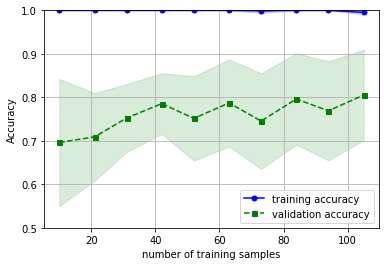

In [70]:
train_sizes, train_scores, test_scores = \
    learning_curve(
                  estimator=forestclf,
                  X=X_transform,
                  y=y_train,
                  train_sizes=np.linspace(0.1,1,10),
                  cv=10,
                  n_jobs=-1
    )
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(
        train_sizes,
        train_mean,
        color='blue',
        marker='o',
        markersize=5,
        label='training accuracy'
        )

plt.fill_between(
                train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,
                color='blue'
                )

plt.plot(
        train_sizes,
        test_mean,
        color='green',
        linestyle='--',
        marker='s',
        markersize=5,
        label='validation accuracy'
        )

plt.fill_between(
                train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15,
                color='green'
                )

plt.grid()
plt.xlabel('number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.show()

In [71]:
forestclf.fit(X_train, y_train)
features_scores = forestclf.feature_importances_
features_scores
index = np.argsort(features_scores)[::-1]


for f in range(X_train.shape[1]):

    print("%2d) %-*s %f" % (f + 1, 30,
                        nombres_columnas[index[f]],
                        features_scores[index[f]]))

plt.title('Importancia de la caracteristica')

plt.bar(range(X_train.shape[1]),
    features_scores[index],
    align='center')

plt.xticks(range(X_train.shape[1]),
    nombres_columnas[index],
    rotation=90)

plt.xlim([-1, 10])

plt.tight_layout()

plt.show()

NameError: name 'nombres_columnas' is not defined

In [74]:
pipeline_optimizer.fit(X_transform, y_train)

Optimization Progress:   0%|          | 0/600 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8018115942028985

Generation 2 - Current best internal CV score: 0.8192028985507246

Generation 3 - Current best internal CV score: 0.8192028985507246

Generation 4 - Current best internal CV score: 0.8192028985507246

Generation 5 - Current best internal CV score: 0.8192028985507246

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=2, max_features=0.45, min_samples_leaf=1, min_samples_split=12, n_estimators=100, subsample=0.45)


TPOTClassifier(generations=5, random_state=1, verbosity=2)

### TPOT + Boruta

In [27]:
pipeline_optimizer = TPOTClassifier()

In [30]:
pipeline_optimizer = TPOTClassifier(
                                    generations=5,
                                    population_size=int(X.shape[0]*0.4),
                                    cv=10,
                                    random_state=10,
                                    verbosity=3,
                                    n_jobs=-1
                                    )

In [31]:
pipeline_optimizer.fit(X_train, y_train)

32 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/348 [00:00<?, ?pipeline/s]

Skipped pipeline #15 due to time out. Continuing to the next pipeline.
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only dual=False, got dual=True.
_pre_test decorator: _random_mutation_operator: num_test=1 Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty..
_pre_test decorator: _random_mutation_operator: num_test=0 Negative values in data passed to MultinomialNB (input X).
_pre_test decorator: _random_mutation_operator: num_test=0 Negative values in data passed to MultinomialNB (input X).
_pre_test decorator: _random_mutation_operator: num_test=0 Negative values in data passed to MultinomialNB (input X).
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty..

Generation 1 - Current Pareto front scores:

-1	0.7128787878787

TPOTClassifier(cv=10, generations=5, n_jobs=-1, population_size=58,
               random_state=10, verbosity=3)

In [32]:
print(pipeline_optimizer.score(X_test, y_test))

0.7666666666666667


### Boruta + SVM